## Import packages

In [1]:
import os, sys
import datetime, time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import pickle
from tensorflow.keras.utils import plot_model

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from utils.window_generator import WindowGenerator

In [2]:
start = time.time()

In [3]:
wkdir = './outputs/unina-cf-nns-norm_mean_std/'
# wkdir = './outputs/unina-cf-nns-norm_min_max/'

MAX_EPOCHS = 1
PATIENCE = 1

dims = '27'
inputDict = {'27': 'lon+lat+traffic',
             '25': 'lon+lat',
             '11': 'lon+traffic',
             '9': 'lon',}
inputStr = inputDict[dims]

resdir = wkdir+dims+'-res/'
os.makedirs(resdir, exist_ok=True)

## Load windowing datasets

In [4]:
def load_dataset(
    inputInfo,
    outdir,
    input_width=None,
    label_width=None,
    shift=None,
):
    if inputInfo == 'lon+lat+traffic':
        inputNum = 27
    elif inputInfo == 'lon+lat':
        inputNum = 25
    elif inputInfo == 'lon+traffic':
        inputNum = 11
    elif inputInfo == 'lon':
        inputNum = 9
    else:
        print('Please specify input information.')
        return 0
        
    casedir = outdir+f'{inputNum}-car/{input_width}_{label_width}_{shift}/'
    print(casedir)
    dsdir = casedir+'saved_data'
    
    ds_load = tf.data.experimental.load(dsdir)
    with open(casedir+'/ds_size.txt', 'r') as f:
        ds_size = int(f.readline())
    with open(casedir+'/column_indices.pkl', 'rb') as f:
        cols_load = pickle.load(f)

    w = WindowGenerator(input_width=input_width, label_width=label_width, shift=shift, ds=ds_load,
                        label_columns=['xAcceleration'], column_indices=cols_load)
    
    w.train, w.val, w.test = w.get_dataset_partitions_tf(ds_size)
    
    return w

#### Select dataset input dimensions

In [5]:
# Data window: 10_10_10, 10_5_5, 5_1_1, 1_1_1
w10_10_10 = load_dataset(inputStr, wkdir, input_width=10, label_width=10, shift=10)
w10_5_5 = load_dataset(inputStr, wkdir, input_width=10, label_width=5, shift=5)
w5_1_1 = load_dataset(inputStr, wkdir, input_width=5, label_width=1, shift=1)
w1_1_1 = load_dataset(inputStr, wkdir, input_width=1, label_width=1, shift=1)

./outputs/unina-cf-nns-norm_mean_std/27-car/10_10_10/
./outputs/unina-cf-nns-norm_mean_std/27-car/10_5_5/
./outputs/unina-cf-nns-norm_mean_std/27-car/5_1_1/
./outputs/unina-cf-nns-norm_mean_std/27-car/1_1_1/


##  Train models

In [6]:
def compile_and_fit(model, window, max_epochs=MAX_EPOCHS, patience=PATIENCE):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    # IPython.display.clear_output()
    model.summary()
    return history

In [7]:
def plot_and_save_history_model(history, model, fname, resdir):
    hist = pd.DataFrame(history.history)
    # hist['epoch'] = history.epoch
    hist.insert(0, 'epoch', history.epoch)
    hist.to_csv(resdir+fname+'.csv', index=False)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Validation Error')
    #plt.ylim([0,100])
    plt.legend() 
    plt.savefig(resdir+fname+'.jpg', bbox_inches='tight')
    plt.show()
    plt.close('all')
    
    plot_model(model,
               to_file=resdir+fname+'_model.png', 
               show_shapes=True, 
               show_dtype=False,
               show_layer_names=False,
               rankdir='TB',  # 'TB' - vertical; 'LR' - horizontal
               expand_nested=True,
               dpi=200)

### Single step models

In [8]:
val_performance = {}
performance = {}

#### Baseline

In [9]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [10]:
w = w1_1_1
fname = 'baseline-w1_1_1'
baseline = Baseline(label_index=w.column_indices['xAcceleration'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance[fname] = baseline.evaluate(w.val)
performance[fname] = baseline.evaluate(w.test, verbose=1)

546/546 [==============================] - 1s 909us/step - loss: 0.0059 - mean_absolute_error: 0.0484


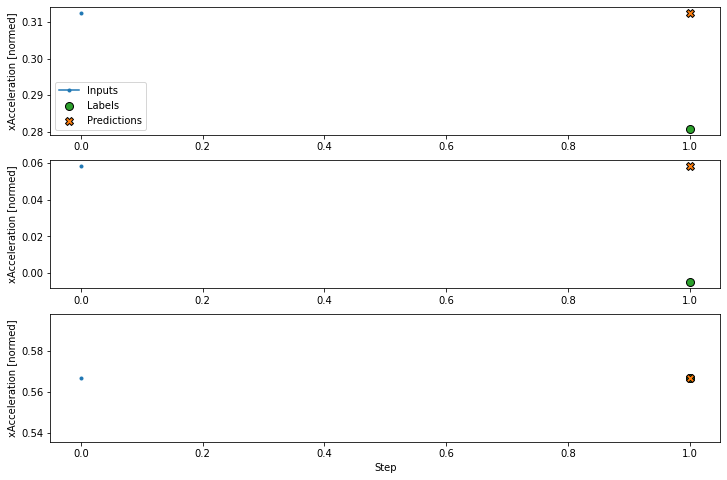

In [11]:
w.plot(baseline)

#### Linear model

In [12]:
def build_linear_model():
    linear = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1)
    ])
    return linear

3812/3812 [==============================] - 9s 2ms/step - loss: 0.6258 - mean_absolute_error: 0.4929 - val_loss: 0.0206 - val_mean_absolute_error: 0.1046
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 1)              28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________
546/546 [==============================] - 1s 1ms/step - loss: 0.0207 - mean_absolute_error: 0.1053


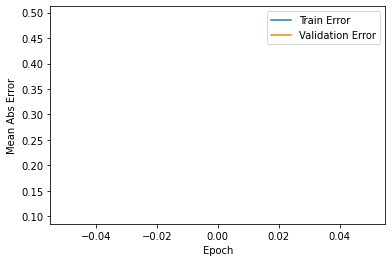

In [13]:
w = w1_1_1
m = build_linear_model()
fname = 'linear-w1_1_1'

history = compile_and_fit(m, w)

val_performance[fname] = m.evaluate(w.val)
performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

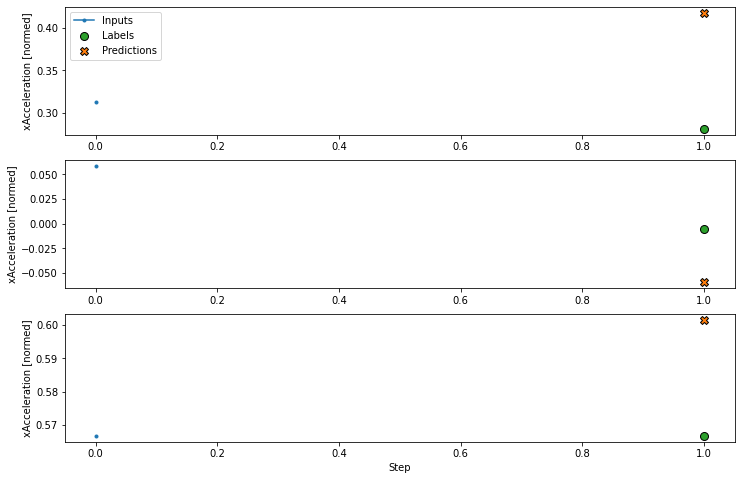

In [14]:
w.plot(m)

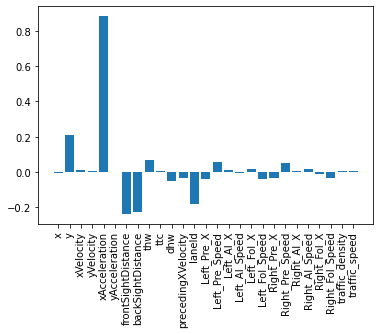

In [15]:
plt.figure()
cols = list(w.column_indices.keys())
plt.bar(x = range(len(cols)),
        height=m.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(cols)))
_ = axis.set_xticklabels(cols, rotation=90)

df_ = pd.DataFrame.from_dict({
    'inputs': cols,
    'weights': m.layers[0].kernel[:,0].numpy(),
})
df_.to_csv(resdir+fname+'-weights.csv', index=False)
plt.savefig(resdir+fname+'-weights.jpg', bbox_inches='tight')
plt.show()
plt.close('all')

#### Dense

In [16]:
def build_dense_model():
    dense = tf.keras.Sequential([
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    return dense

3812/3812 [==============================] - 15s 4ms/step - loss: 0.0575 - mean_absolute_error: 0.1418 - val_loss: 0.0405 - val_mean_absolute_error: 0.0952
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 64)             1792      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 64)             4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              65        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________
546/546 [==============================] - 1s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.0951


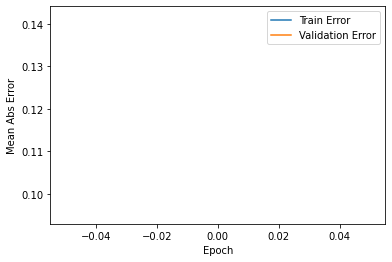

In [17]:
w = w1_1_1
m = build_dense_model()
fname = 'dense-w1_1_1'

history = compile_and_fit(m, w)

val_performance[fname] = m.evaluate(w.val)
performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

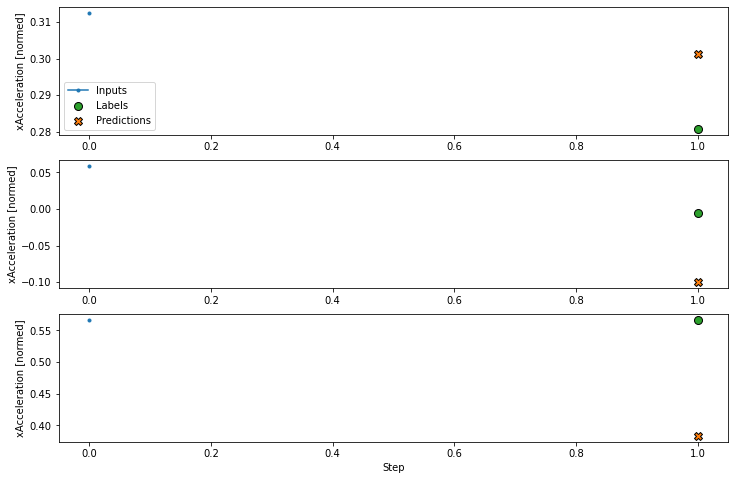

In [18]:
w.plot(m)

#### N-step dense

In [19]:
def build_n_step_dense_model():
    n_step_dense = tf.keras.Sequential([
        # Shape: (time, features) => (time*features)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=1),
        # Add back the time dimension.
        # Shape: (outputs) => (1, outputs)
        tf.keras.layers.Reshape([1, -1]),
    ])
    return n_step_dense

3595/3595 [==============================] - 10s 3ms/step - loss: 0.1243 - mean_absolute_error: 0.2152 - val_loss: 0.0233 - val_mean_absolute_error: 0.1134
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 135)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4352      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
_________________________________________________________________
reshape (Reshape)            (None, 1, 1)              0         
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
____________________________

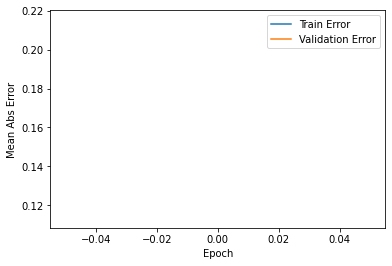

In [20]:
w = w5_1_1
m = build_n_step_dense_model()
fname = 'n_step_dense-w5_1_1'

history = compile_and_fit(m, w)

val_performance[fname] = m.evaluate(w.val)
performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

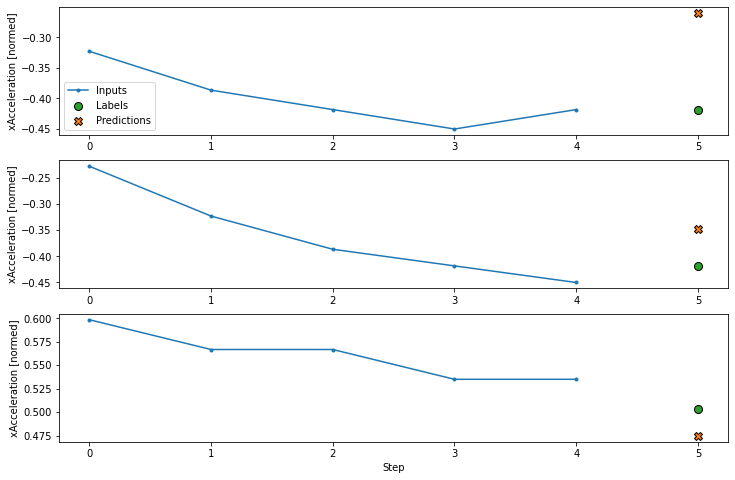

In [21]:
w.plot(m)

#### Convolution neural network

In [22]:
def build_conv_model(conv_width=None):
    conv_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32,
                               kernel_size=(conv_width,),
                               activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=1),
    ])
    return conv_model

3595/3595 [==============================] - 15s 4ms/step - loss: 0.0978 - mean_absolute_error: 0.1947 - val_loss: 0.0202 - val_mean_absolute_error: 0.1041
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             4352      
_________________________________________________________________
dense_7 (Dense)              (None, 1, 32)             1056      
_________________________________________________________________
dense_8 (Dense)              (None, 1, 1)              33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
515/515 [==============================] - 1s 2ms/step - loss: 0.0206 - mean_absolute_error: 0.1061


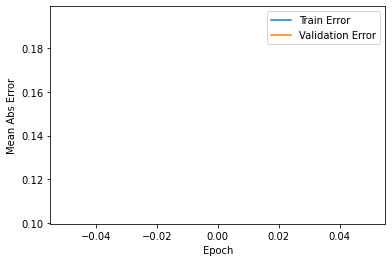

In [23]:
w = w5_1_1
m = build_conv_model(conv_width=w.input_width)
fname = 'conv-w5_1_1'

history = compile_and_fit(m, w)

val_performance[fname] = m.evaluate(w.val)
performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

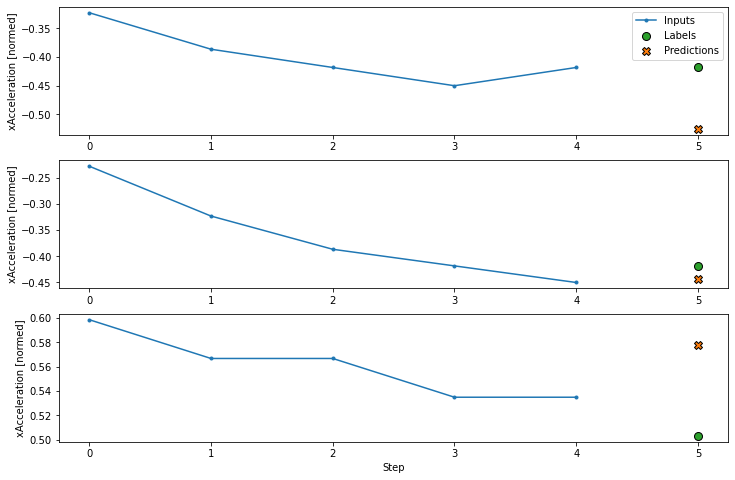

In [24]:
w.plot(m)

#### Recurrent neural network

In [25]:
def build_lstm_model():
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])
    return lstm_model

3595/3595 [==============================] - 15s 4ms/step - loss: 0.0783 - mean_absolute_error: 0.1488 - val_loss: 0.0073 - val_mean_absolute_error: 0.0553
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                7680      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 7,713
Trainable params: 7,713
Non-trainable params: 0
_________________________________________________________________
515/515 [==============================] - 1s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0549


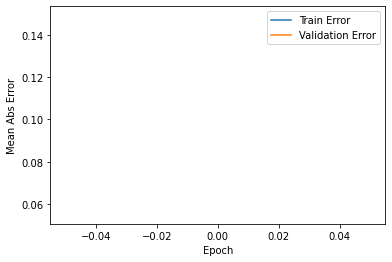

In [26]:
w = w5_1_1
m = build_lstm_model()
fname = 'lstm-w5_1_1'

history = compile_and_fit(m, w)

val_performance[fname] = m.evaluate(w.val)
performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

#### Performance
With this dataset typically each of the models does slightly better than the one before it:

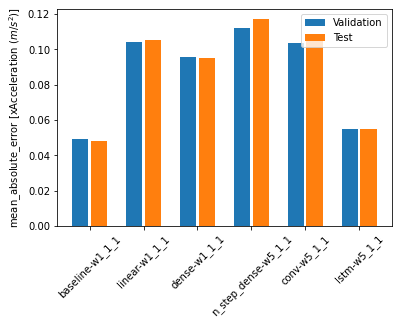

In [27]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = m.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]
model_name = list(performance.keys())

plt.figure()
plt.ylabel('mean_absolute_error [xAcceleration ($m/s^2$)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

df_single = pd.DataFrame.from_dict({
    'model': model_name,
    'val_mae': val_mae,
    'test_mae': test_mae,
})
df_single.to_csv(resdir+'performance_single_step_models.csv', index=False)
plt.savefig(resdir+'performance_single_step_models.jpg', bbox_inches='tight')
plt.show()
plt.close('all')

### Multi-step models

In [28]:
multi_val_performance = {}
multi_performance = {}

#### Baselines

##### Last baseline

In [29]:
class MultiStepLastBaseline(tf.keras.Model):
    def __init__(self, label_index=None, out_steps=None):
        super().__init__()
        self.label_index = label_index
        self.out_steps=out_steps
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, self.label_index][:, :, tf.newaxis], [1, self.out_steps, 1])

In [30]:
w = w10_10_10
fname = 'last_baseline-w10_10_10'
last_baseline = MultiStepLastBaseline(label_index=w.column_indices['xAcceleration'], out_steps=w.label_width)
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance[fname] = last_baseline.evaluate(w.val)
multi_performance[fname] = last_baseline.evaluate(w.test, verbose=1)

456/456 [==============================] - 1s 1ms/step - loss: 0.2232 - mean_absolute_error: 0.2770


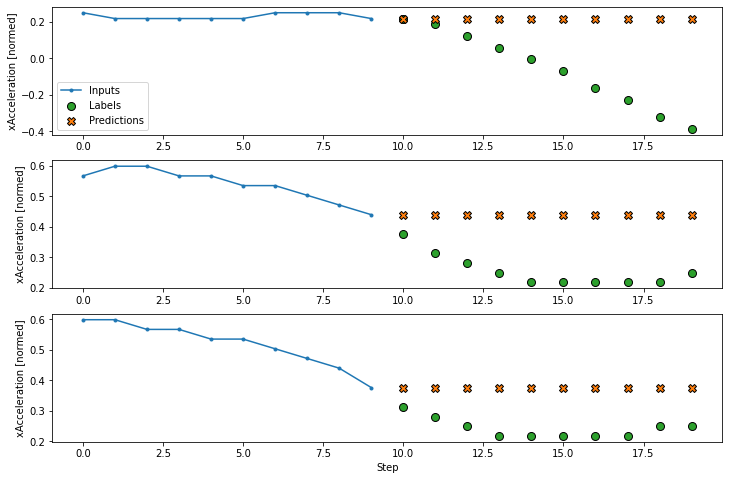

In [31]:
w.plot(last_baseline)

In [32]:
w = w10_5_5
fname = 'last_baseline-w10_5_5'
last_baseline = MultiStepLastBaseline(label_index=w.column_indices['xAcceleration'], out_steps=w.label_width)
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance[fname] = last_baseline.evaluate(w.val)
multi_performance[fname] = last_baseline.evaluate(w.test, verbose=1)

483/483 [==============================] - 1s 1ms/step - loss: 0.0655 - mean_absolute_error: 0.1472


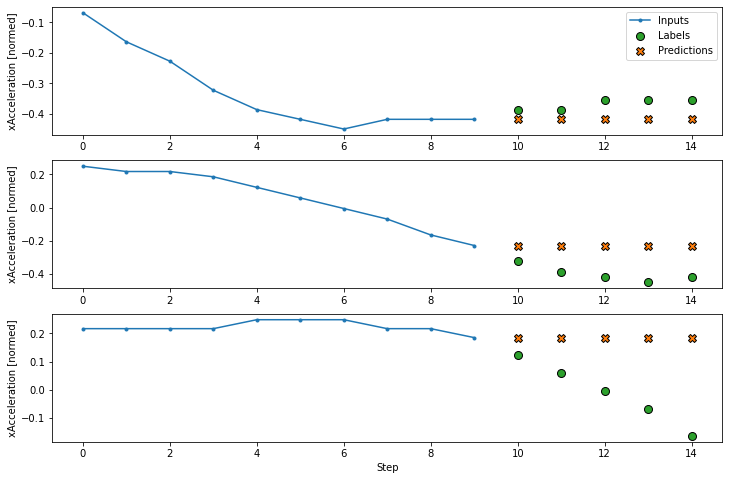

In [33]:
w.plot(last_baseline)

##### Repeat baseline

class RepeatBaseline(tf.keras.Model):
    def __init__(self, label_index=None, out_steps=None):
        super().__init__()
        self.label_index = label_index
        self.out_steps=out_steps
    def call(self, inputs):
        return inputs[:, -self.out_steps:, self.label_index][:, :, tf.newaxis]

w = w10_10_10
fname = 'repeat_baseline-w10_10_10'
repeat_baseline = RepeatBaseline(label_index=w.column_indices['xAcceleration'], out_steps=w.label_width)
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance[fname] = repeat_baseline.evaluate(w.val)
multi_performance[fname] = repeat_baseline.evaluate(w.test, verbose=1)

w.plot(repeat_baseline)

#### Single-shot models

##### Linear

In [34]:
def build_multi_linear_model(out_steps=None, num_features=None):
    multi_linear_model = tf.keras.Sequential([
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(out_steps*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([out_steps, num_features])
    ])
    return multi_linear_model

3192/3192 [==============================] - 9s 3ms/step - loss: 0.4287 - mean_absolute_error: 0.4237 - val_loss: 0.1901 - val_mean_absolute_error: 0.2738
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 27)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1, 270)            7560      
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 27)            0         
Total params: 7,560
Trainable params: 7,560
Non-trainable params: 0
_________________________________________________________________
456/456 [==============================] - 1s 2ms/step - loss: 0.2144 - mean_absolute_error: 0.2875


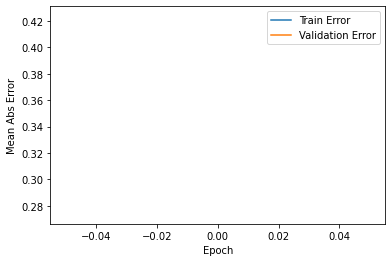

In [35]:
w = w10_10_10
m = build_multi_linear_model(out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_linear-w10_10_10'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

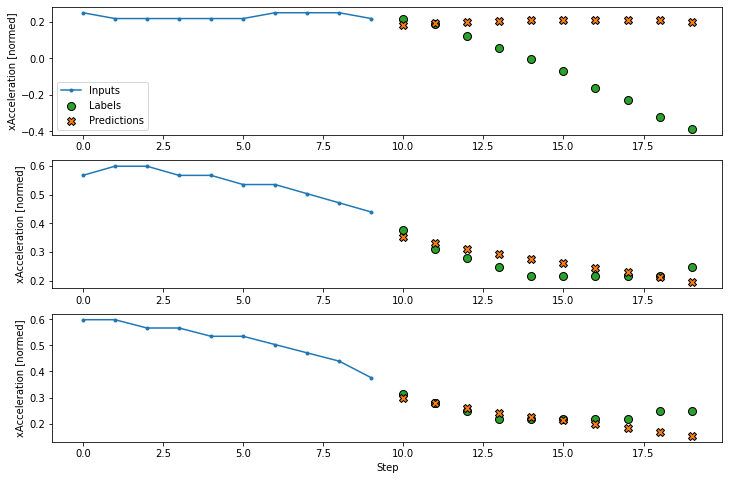

In [36]:
w.plot(m)

3373/3373 [==============================] - 10s 3ms/step - loss: 0.3483 - mean_absolute_error: 0.3677 - val_loss: 0.0650 - val_mean_absolute_error: 0.1634
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 27)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1, 135)            3780      
_________________________________________________________________
reshape_2 (Reshape)          (None, 5, 27)             0         
Total params: 3,780
Trainable params: 3,780
Non-trainable params: 0
_________________________________________________________________
483/483 [==============================] - 1s 2ms/step - loss: 0.0802 - mean_absolute_error: 0.1785


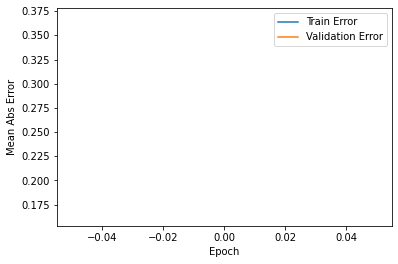

In [37]:
w = w10_5_5
m = build_multi_linear_model(out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_linear-w10_5_5'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

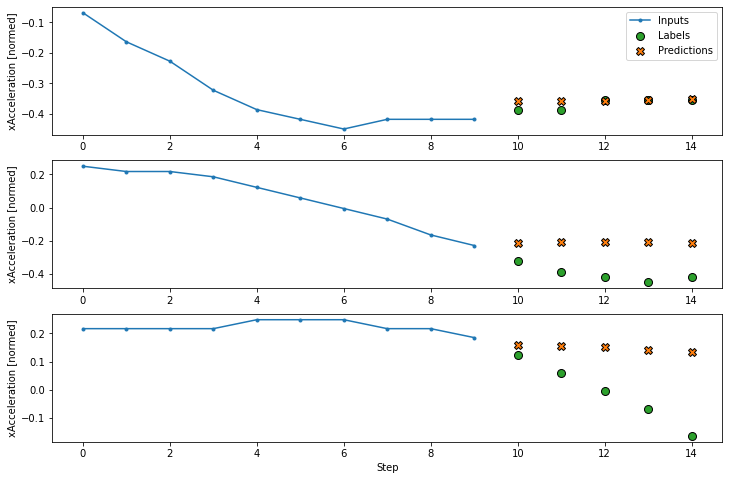

In [38]:
w.plot(m)

##### Dense

In [39]:
def build_multi_dense_model(out_steps=None, num_features=None):
    multi_dense_model = tf.keras.Sequential([
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation='relu'),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(out_steps*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([out_steps, num_features])
    ])
    return multi_dense_model

3192/3192 [==============================] - 11s 3ms/step - loss: 0.2413 - mean_absolute_error: 0.3143 - val_loss: 0.1744 - val_mean_absolute_error: 0.2823
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 1, 27)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1, 512)            14336     
_________________________________________________________________
dense_13 (Dense)             (None, 1, 270)            138510    
_________________________________________________________________
reshape_3 (Reshape)          (None, 10, 27)            0         
Total params: 152,846
Trainable params: 152,846
Non-trainable params: 0
_________________________________________________________________
456/456 [==============================] - 1s 2ms/step - loss: 0.1862 - mean_absolute_erro

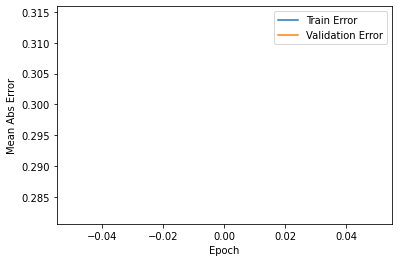

In [40]:
w = w10_10_10
m = build_multi_dense_model(out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_dense-w10_10_10'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

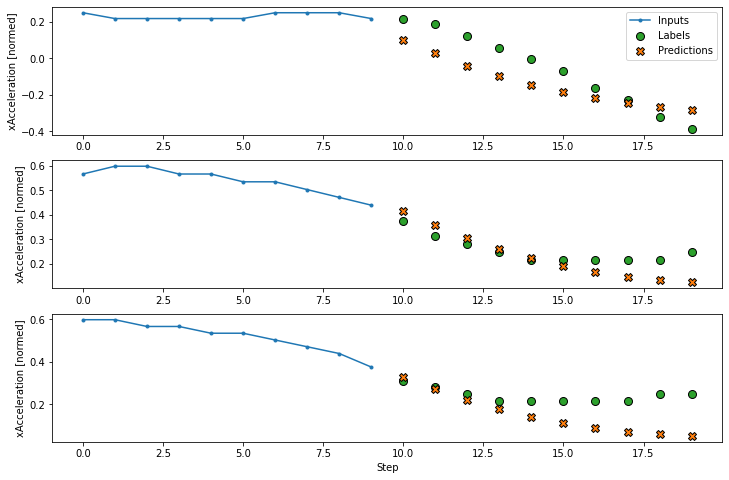

In [41]:
w.plot(m)

3373/3373 [==============================] - 12s 3ms/step - loss: 0.1562 - mean_absolute_error: 0.2079 - val_loss: 0.0691 - val_mean_absolute_error: 0.1653
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 1, 27)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 1, 512)            14336     
_________________________________________________________________
dense_15 (Dense)             (None, 1, 135)            69255     
_________________________________________________________________
reshape_4 (Reshape)          (None, 5, 27)             0         
Total params: 83,591
Trainable params: 83,591
Non-trainable params: 0
_________________________________________________________________
483/483 [==============================] - 1s 2ms/step - loss: 0.0644 - mean_absolute_error:

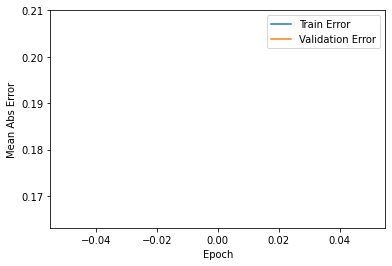

In [42]:
w = w10_5_5
m = build_multi_dense_model(out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_dense-w10_5_5'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

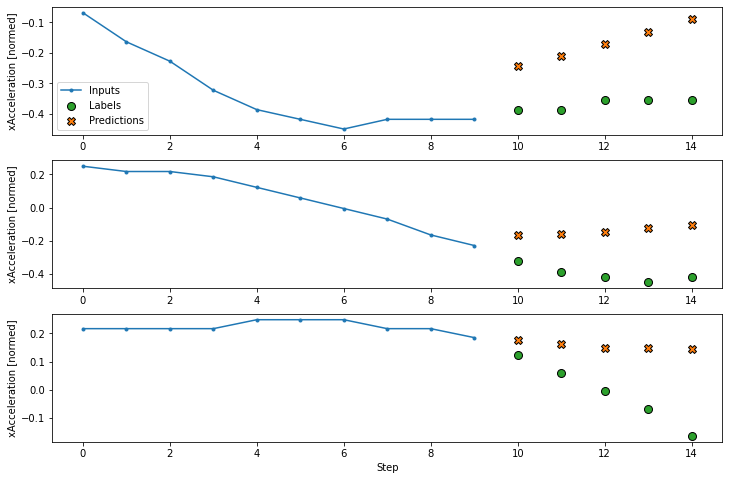

In [43]:
w.plot(m)

##### CNN

In [44]:
def build_multi_conv_model(conv_width=None, out_steps=None, num_features=None):
    multi_conv_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, conv_width, features]
        tf.keras.layers.Lambda(lambda x: x[:, -conv_width:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(conv_width)),
        # Shape => [batch, 1,  out_steps*features]
        tf.keras.layers.Dense(out_steps*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([out_steps, num_features])
    ])
    return multi_conv_model

3192/3192 [==============================] - 11s 3ms/step - loss: 0.3164 - mean_absolute_error: 0.3825 - val_loss: 0.1842 - val_mean_absolute_error: 0.2905
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 10, 27)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 256)            69376     
_________________________________________________________________
dense_16 (Dense)             (None, 1, 270)            69390     
_________________________________________________________________
reshape_5 (Reshape)          (None, 10, 27)            0         
Total params: 138,766
Trainable params: 138,766
Non-trainable params: 0
_________________________________________________________________
456/456 [==============================] - 1s 2ms/step - loss: 0.1962 - mean_absolute_erro

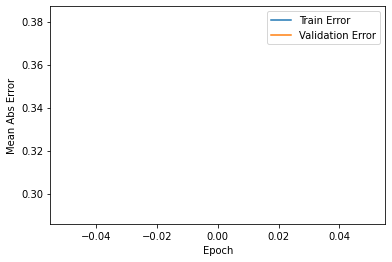

In [45]:
w = w10_10_10
m = build_multi_conv_model(conv_width=w.input_width, out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_conv-w10_10_10'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

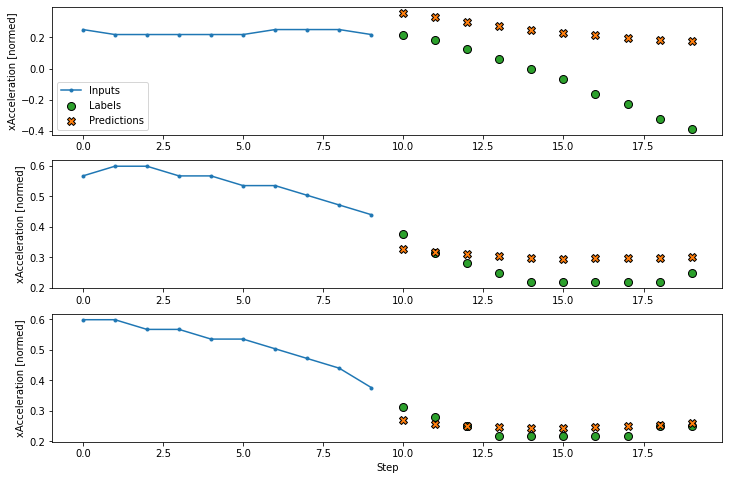

In [46]:
w.plot(m)

3373/3373 [==============================] - 10s 3ms/step - loss: 0.1582 - mean_absolute_error: 0.2751 - val_loss: 0.0710 - val_mean_absolute_error: 0.1843
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 10, 27)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 256)            69376     
_________________________________________________________________
dense_17 (Dense)             (None, 1, 135)            34695     
_________________________________________________________________
reshape_6 (Reshape)          (None, 5, 27)             0         
Total params: 104,071
Trainable params: 104,071
Non-trainable params: 0
_________________________________________________________________
483/483 [==============================] - 1s 2ms/step - loss: 0.0773 - mean_absolute_err

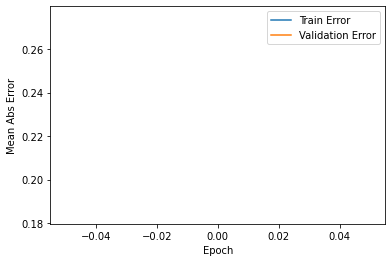

In [47]:
w = w10_5_5
m = build_multi_conv_model(conv_width=w.input_width, out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_conv-w10_5_5'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

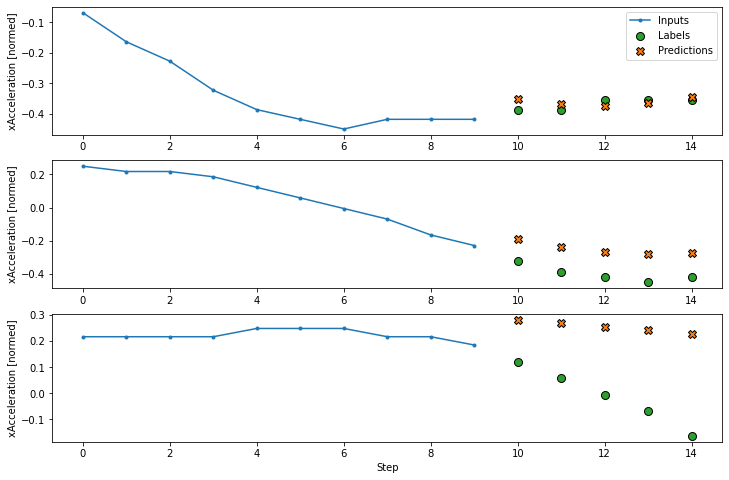

In [48]:
w.plot(m)

##### RNN

In [49]:
def build_multi_lstm_model(out_steps=None, num_features=None):
    multi_lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(out_steps*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([out_steps, num_features])
    ])
    return multi_lstm_model

3192/3192 [==============================] - 13s 4ms/step - loss: 0.2588 - mean_absolute_error: 0.3129 - val_loss: 0.1410 - val_mean_absolute_error: 0.2231
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                7680      
_________________________________________________________________
dense_18 (Dense)             (None, 270)               8910      
_________________________________________________________________
reshape_7 (Reshape)          (None, 10, 27)            0         
Total params: 16,590
Trainable params: 16,590
Non-trainable params: 0
_________________________________________________________________
456/456 [==============================] - 1s 2ms/step - loss: 0.1027 - mean_absolute_error: 0.2024


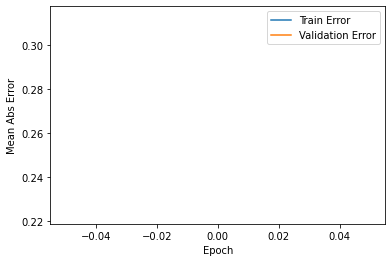

In [50]:
w = w10_10_10
m = build_multi_lstm_model(out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_lstm-w10_10_10'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

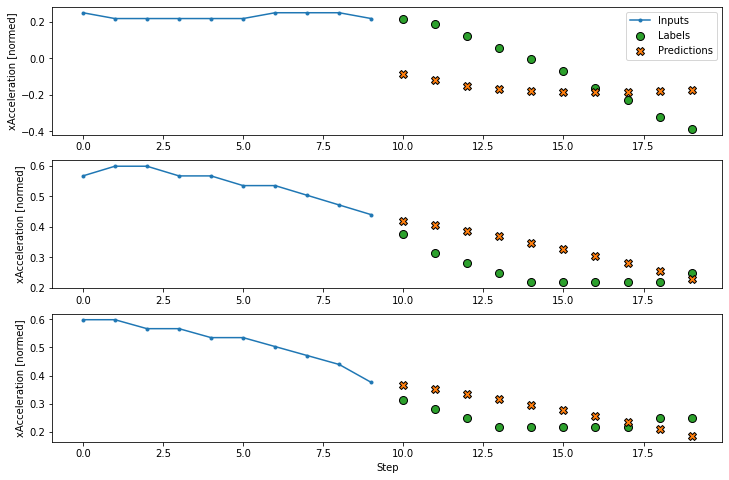

In [51]:
w.plot(m)

3373/3373 [==============================] - 15s 4ms/step - loss: 0.1525 - mean_absolute_error: 0.2109 - val_loss: 0.0361 - val_mean_absolute_error: 0.1243
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                7680      
_________________________________________________________________
dense_19 (Dense)             (None, 135)               4455      
_________________________________________________________________
reshape_8 (Reshape)          (None, 5, 27)             0         
Total params: 12,135
Trainable params: 12,135
Non-trainable params: 0
_________________________________________________________________
483/483 [==============================] - 1s 2ms/step - loss: 0.0399 - mean_absolute_error: 0.1290


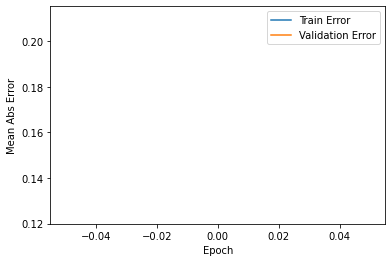

In [52]:
w = w10_5_5
m = build_multi_lstm_model(out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_lstm-w10_5_5'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

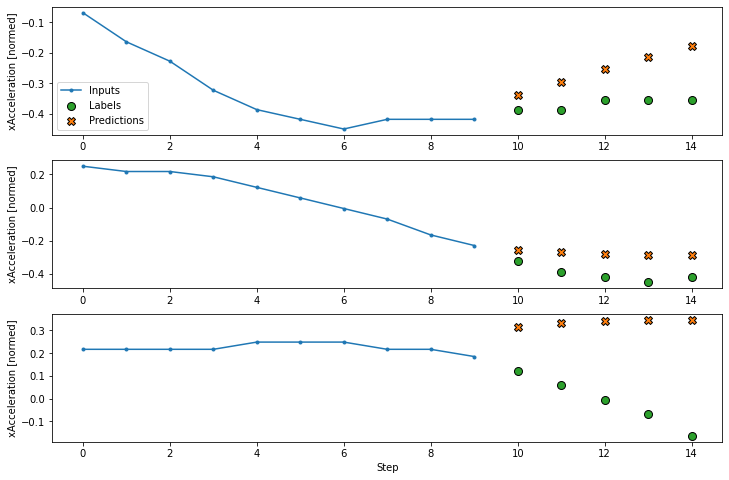

In [53]:
w.plot(m)

#### Autoregressive mode

##### RNN

In [54]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps=None, num_features=None):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

3192/3192 [==============================] - 126s 39ms/step - loss: 0.3636 - mean_absolute_error: 0.3851 - val_loss: 0.2193 - val_mean_absolute_error: 0.3147
Model: "feed_back"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_cell_3 (LSTMCell)       multiple                  7680      
_________________________________________________________________
rnn (RNN)                    multiple                  7680      
_________________________________________________________________
dense_20 (Dense)             multiple                  891       
Total params: 8,571
Trainable params: 8,571
Non-trainable params: 0
_________________________________________________________________
456/456 [==============================] - 4s 9ms/step - loss: 0.2091 - mean_absolute_error: 0.3090


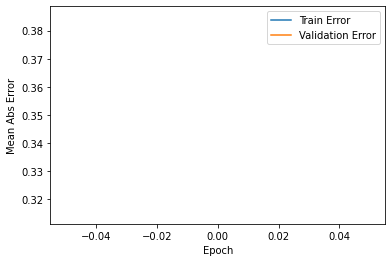

In [55]:
w = w10_10_10
m = FeedBack(units=32, out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_ar_lstm-w10_10_10'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

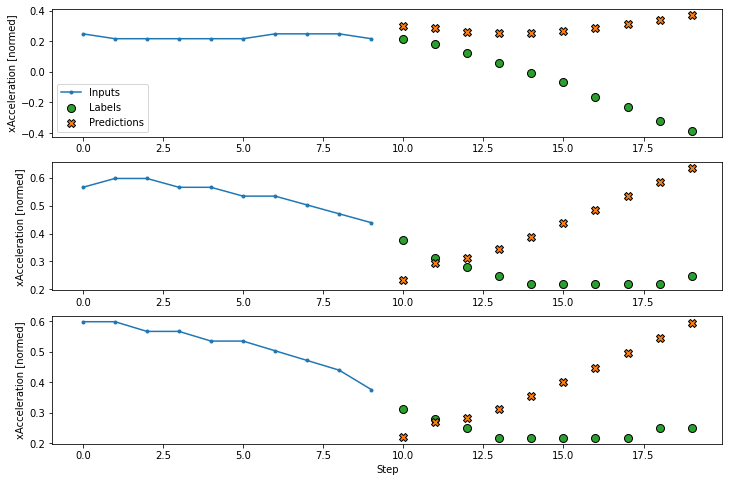

In [56]:
w.plot(m)

3373/3373 [==============================] - 115s 34ms/step - loss: 0.1881 - mean_absolute_error: 0.2495 - val_loss: 0.0528 - val_mean_absolute_error: 0.1469
Model: "feed_back_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_cell_4 (LSTMCell)       multiple                  7680      
_________________________________________________________________
rnn_1 (RNN)                  multiple                  7680      
_________________________________________________________________
dense_21 (Dense)             multiple                  891       
Total params: 8,571
Trainable params: 8,571
Non-trainable params: 0
_________________________________________________________________
483/483 [==============================] - 3s 7ms/step - loss: 0.0456 - mean_absolute_error: 0.1411


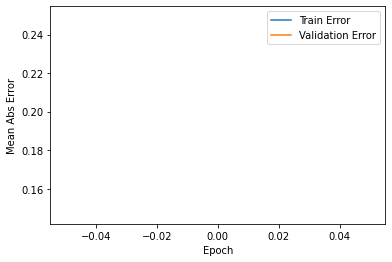

In [57]:
w = w10_5_5
m = FeedBack(units=32, out_steps=w.label_width, num_features=len(w.column_indices))
fname = 'multi_ar_lstm-w10_5_5'

history = compile_and_fit(m, w)

multi_val_performance[fname] = m.evaluate(w.val)
multi_performance[fname] = m.evaluate(w.test, verbose=1)

plot_and_save_history_model(history, m, fname, resdir)

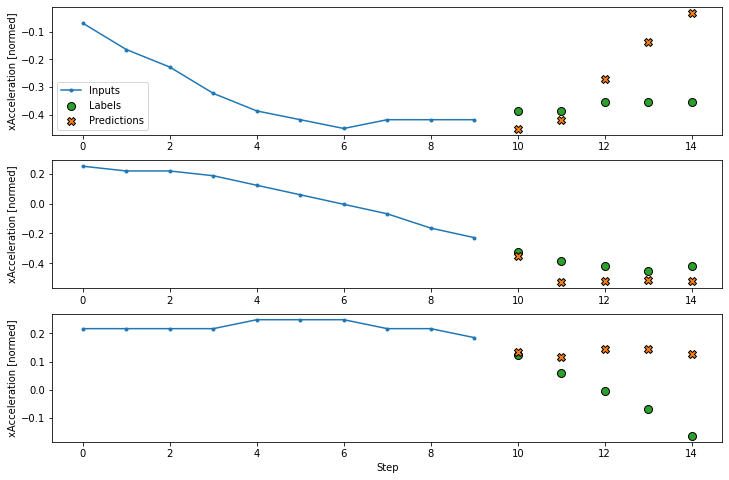

In [58]:
w.plot(m)

#### Performance

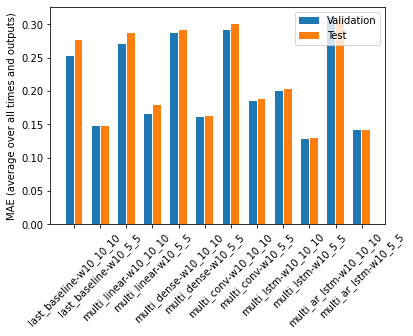

In [59]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = m.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]
model_name = list(multi_performance.keys())

plt.figure()
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
df_multi = pd.DataFrame.from_dict({
    'model': model_name,
    'val_mae': val_mae,
    'test_mae': test_mae,
})
df_multi.to_csv(resdir+'performance_multi_step_models.csv', index=False)
plt.savefig(resdir+'performance_multi_step_models.jpg', bbox_inches='tight')
plt.show()
plt.close('all')

## End

In [60]:
end = time.time()
print(end - start)

478.0032169818878
